In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def run_nasch(L=1000, v_max=5, p=0.3, density=0.2,
              steps=3000, warmup=1000, rng=None):
    """
    Return steady-state average speed for a single NaSch run.
    """
    if rng is None:
        rng = np.random.default_rng()
    N = int(round(density * L))
    # sample distinct initial positions and sort from left to right
    pos = np.sort(rng.choice(L, size=N, replace=False))
    v = rng.integers(low=0, high=v_max+1, size=N)

    sum_v = 0.0
    count = 0

    for t in range(steps):
        # 1) accelerate
        v = np.minimum(v + 1, v_max)

        # 2) slow down due to leader (gap)
        # compute gaps to next car ahead on ring
        next_pos = np.roll(pos, -1)
        gaps = (next_pos - pos - 1) % L
        v = np.minimum(v, gaps)

        # 3) randomization (only if v > 0)
        mask = (v > 0) & (rng.random(len(v)) < p)
        v[mask] -= 1

        # 4) move
        pos = (pos + v) % L
        # keep order to preserve leader mapping next step
        order = np.argsort(pos)
        pos = pos[order]
        v = v[order]

        # accumulate steady-state stats
        if t >= warmup:
            sum_v += v.mean()
            count += 1

    avg_speed = sum_v / max(count, 1)
    return avg_speed

In [3]:
def estimate_flow(L, v_max, p, density, steps=3000, warmup=1000, reps=3, seed=42):
    """
    Monte Carlo average of steady-state flow J = rho * avg_speed.
    """
    rng = np.random.default_rng(seed)
    avg = 0.0
    for r in range(reps):
        # independent streams per repetition
        sub_rng = np.random.default_rng(rng.integers(0, 2**31-1))
        vbar = run_nasch(L=L, v_max=v_max, p=p, density=density,
                         steps=steps, warmup=warmup, rng=sub_rng)
        avg += density * vbar
    return avg / reps

In [4]:
L = 2000
v_max = 5
steps, warmup, reps = 4000, 1500, 3

densities = np.linspace(0.01, 0.99, 50)
p_list = [0.01, 0.1, 0.3, 0.4, 0.5, 0.75]

flows_by_p = {}
for p in p_list:
    flows = []
    for rho in densities:
        J = estimate_flow(L, v_max, p, rho, steps=steps, warmup=warmup, reps=reps)
        flows.append(J)
    flows_by_p[p] = np.array(flows)

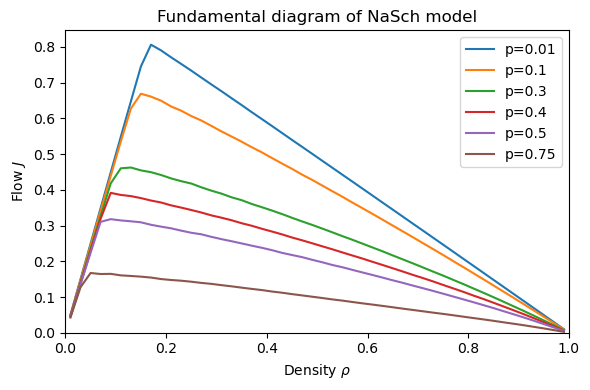

In [5]:
plt.figure(figsize=(6,4))
for p, J in flows_by_p.items():
    plt.plot(densities, J, label=f"p={p}")

plt.xlabel(r"Density $\rho$")
plt.ylabel(r"Flow $J$")
plt.title("Fundamental diagram of NaSch model")
plt.xlim(0, 1)
plt.ylim(0, None)
plt.legend()
plt.tight_layout()
plt.show()

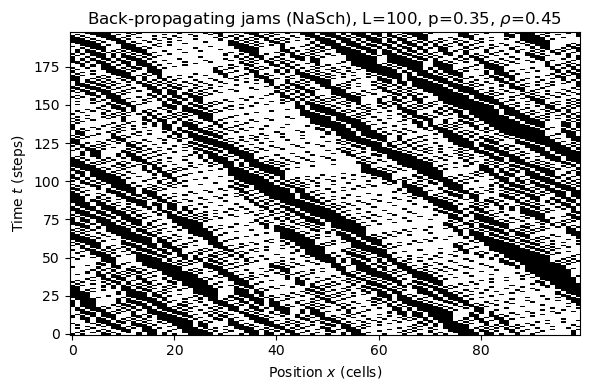

In [6]:
def nasch_history(L=100, v_max=5, p=0.35, density=0.45, steps=2000, warmup=200, seed=7):
    """
    Run NaSch on a ring and return a binary space-time array:
    rows = time, cols = position; 1 = car present, 0 = empty.
    """
    rng = np.random.default_rng(seed)
    N = int(round(density * L))
    pos = np.sort(rng.choice(L, size=N, replace=False))
    v = rng.integers(low=0, high=v_max+1, size=N)

    space_time = np.zeros((steps - warmup, L), dtype=np.uint8)

    for t in range(steps):
        # 1) accelerate
        v = np.minimum(v + 1, v_max)

        # 2) slow down to gap
        next_pos = np.roll(pos, -1)
        gaps = (next_pos - pos - 1) % L
        v = np.minimum(v, gaps)

        # 3) randomization (only if v>0)
        mask = (v > 0) & (rng.random(len(v)) < p)
        v[mask] -= 1

        # 4) move
        pos = (pos + v) % L
        order = np.argsort(pos)
        pos, v = pos[order], v[order]

        # record after warmup
        if t >= warmup:
            space_time[t - warmup, pos] = 1

    return space_time

# --- simulate and plot back-propagation for L=100 ---
L = 100
p = 0.35      # random slow-down prob (induces jams)
rho = 0.45    # density (tune 0.35–0.55 to see clear waves)
steps = 200
warmup = 2

st = nasch_history(L=L, v_max=5, p=p, density=rho, steps=steps, warmup=warmup, seed=1)

plt.figure(figsize=(6,4))
plt.imshow(st, aspect='auto', cmap='binary', origin='lower', interpolation='nearest')
plt.xlabel('Position $x$ (cells)')
plt.ylabel('Time $t$ (steps)')
plt.title(f'Back-propagating jams (NaSch), L={L}, p={p}, $\\rho$={rho:.2f}')
plt.tight_layout()
plt.show()

In [44]:
def run_param_rc(fontsize=23):
    import matplotlib.pyplot as plt
    plt.rcParams.update({
        'axes.labelsize': fontsize,
        'axes.titlesize': fontsize,
        'font.size': fontsize,
        'savefig.dpi': 75,
        'lines.linewidth': 2.0,
        'lines.markersize': 8,
        'legend.fontsize': fontsize * 0.9,
        'legend.labelspacing': .3,
        'legend.columnspacing': .3,
        'legend.handletextpad': .1,
        'text.usetex': False,                 # <- use mathtext, no LaTeX needed
        'mathtext.fontset': 'stix',
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'STIXGeneral', 'DejaVu Serif'],
    })


In [45]:
run_param_rc(fontsize=23)

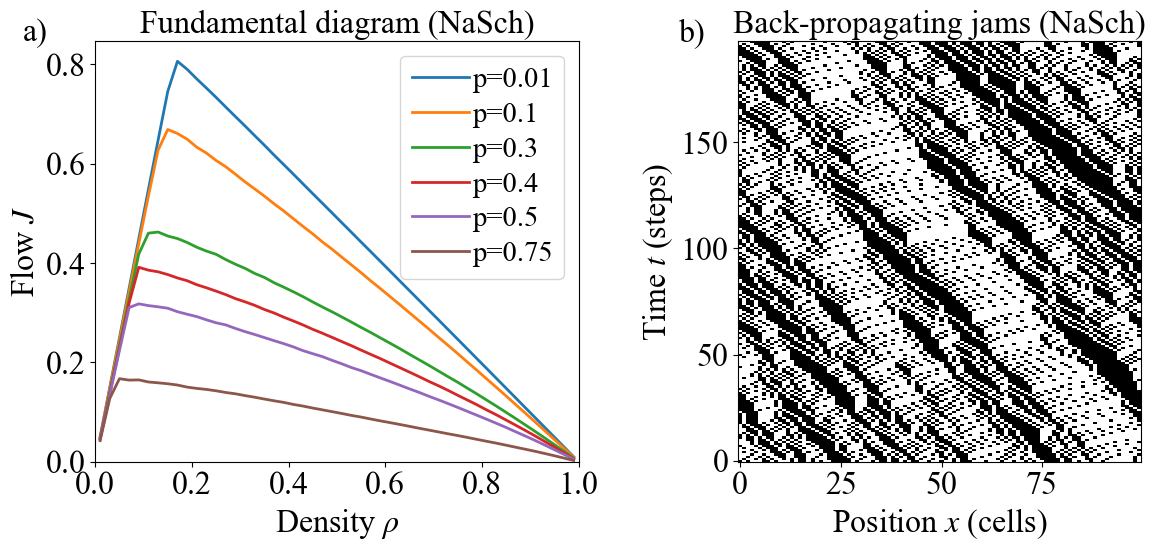

In [46]:
# Create a figure with 2 subplots side-by-side
fig, (ax_fd, ax_bp) = plt.subplots(1, 2, 
                                             figsize=(12, 6),
                                             gridspec_kw={"width_ratios":[1.2,1]})
a = -.15
b = 1.00
ax_fd.annotate('a)', xy = (a,b), xycoords='axes fraction')
ax_bp.annotate('b)', xy = (a,b), xycoords='axes fraction')

ax1 = ax_fd  # rename for clarity
for p, J in flows_by_p.items():
    ax1.plot(densities, J, label=f"p={p}")

ax1.set_xlabel(r"Density $\rho$")
ax1.set_ylabel(r"Flow $J$")
ax1.set_title("Fundamental diagram (NaSch)")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, None)
ax1.legend()

ax2 = ax_bp
ax2.imshow(st, aspect='auto', cmap='binary', origin='lower', interpolation='nearest')
ax2.set_xlabel('Position $x$ (cells)')
ax2.set_ylabel('Time $t$ (steps)')
ax2.set_title(f'Back-propagating jams (NaSch)')

plt.tight_layout()
plt.savefig("nasch_model.pdf")
plt.show()